In [1]:
import os.path

from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
from collections import defaultdict
import time
import matplotlib.pyplot as plt

from args import *
from utils import *
from model import *

In [2]:
class Args:
    def __init__(self):
        self.dataset = 'phone-email'
        self.ratio = 0.2
        self.use_attr = False
        self.device = 'cpu'
        self.model = 'BRIGHT'
        self.num_layers = 1
        self.hidden_dim = 128
        self.out_dim = 128
        self.lambda_w = 1
        self.lambda_edge = 0
        self.lambda_total = 1e-2
        self.in_iter = 5
        self.out_iter = 10
        self.lr = 1e-3
        self.epochs = 50

In [3]:
args = Args()
# check compatibility between dataset and use_attr
if args.dataset == 'noisy-cora1-cora2':
    assert args.use_attr is True, 'noisy-cora1-cora2 requires using node attributes'
elif args.dataset == 'foursquare-twitter' or args.dataset == 'phone-email':
    assert args.use_attr is False, f'{args.dataset} does not have node attributes'

# load data and build networkx graphs
np_dtype = np.float64
torch_dtype = torch.float64
print("Loading data...", end=" ")
edge_index1, edge_index2, x1, x2, anchor_links, test_pairs = load_data(f"datasets/{args.dataset}", args.ratio,
                                                                       args.use_attr, dtype=np_dtype)
anchor1, anchor2 = anchor_links[:, 0], anchor_links[:, 1]
G1, G2 = build_nx_graph(edge_index1, anchor1, x1), build_nx_graph(edge_index2, anchor2, x2)
print("Done")

rwr1, rwr2 = get_rwr_matrix(G1, G2, anchor_links, args.dataset, args.ratio, dtype=np_dtype)
if x1 is None:
    x1 = rwr1
if x2 is None:
    x2 = rwr2

# device setting
assert torch.cuda.is_available() or args.device == 'cpu', 'CUDA is not available'
device = torch.device(args.device)
torch.set_default_dtype(torch.float64)

# build PyG Data objects
G1_tg = build_tg_graph(edge_index1, x1, rwr1, dtype=torch_dtype).to(device)
G2_tg = build_tg_graph(edge_index2, x2, rwr2, dtype=torch_dtype).to(device)

# model setting
input_dim = G1_tg.x.shape[1]
hidden_dim = args.hidden_dim
output_dim = args.out_dim

Loading data... Done
Loading RWR scores from datasets/rwr/rwr_emb_phone-email_0.2.npz... Done


In [48]:
model = BRIGHT(input_dim=input_dim, hidden_dim=output_dim, output_dim=output_dim).to(device)
if args.model == 'PGNA':
    model = PGNA(input_dim=input_dim,
                 feature_dim=output_dim,
                 anchor_dim=anchor_links.shape[0],
                 hidden_dim=output_dim,
                 output_dim=output_dim,
                 num_layers=args.num_layers).to(device)
elif args.model == 'RWRNet':
    model = RWRNet(num_layers=args.num_layers,
                   input_dim=input_dim,
                   output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = FusedGWLoss(G1_tg, G2_tg, anchor1, anchor2,
                        lambda_w=args.lambda_w,
                        lambda_edge=args.lambda_edge,
                        lambda_total=args.lambda_total,
                        in_iter=args.in_iter,
                        out_iter=args.out_iter).to(device)
scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs)
epoch = 0

In [66]:
r1 = G1_tg.rwr / torch.linalg.norm(G1_tg.rwr, ord=2, dim=1, keepdim=True)
r2 = G2_tg.rwr / torch.linalg.norm(G2_tg.rwr, ord=2, dim=1, keepdim=True)
crossC = torch.exp(-r1 @ r2.T)
rank_cross_row = torch.argsort(crossC, dim=1)
rank_cross_col = torch.argsort(crossC, dim=0)
print(rank_cross_row)
print(rank_cross_col)

tensor([[  0, 631, 888,  ..., 854, 212,  99],
        [  1, 705, 162,  ..., 854,  99,   0],
        [296, 877, 718,  ..., 669, 396, 854],
        ...,
        [997, 682, 550,  ..., 575, 854, 340],
        [296, 877, 718,  ..., 396, 854,   0],
        [503, 999,  17,  ...,   0, 396, 854]])
tensor([[  0,   1, 529,  ..., 889, 889, 889],
        [383, 970, 408,  ..., 555, 555, 555],
        [290, 155, 998,  ..., 206, 206, 206],
        ...,
        [ 99, 898, 471,  ..., 863, 863, 863],
        [952, 952,   0,  ..., 898, 898, 898],
        [589,   0, 898,  ...,   0,   0,   0]])


In [73]:
crossC[2, 296]

tensor(0.3882)

In [76]:
rank_cross_col[:100, 296]

tensor([770, 296, 432, 264, 551, 511, 365, 657, 868, 690, 614, 830, 701, 184,
        363, 160, 904, 531, 265, 877, 998,  53, 334, 875, 719, 441, 292, 408,
        438, 765, 321, 588, 594, 718, 476, 306, 404, 391, 293, 454, 843, 498,
        165, 981, 101, 895, 798, 529, 364, 344, 458, 776, 564, 505, 274, 163,
        254, 672, 161, 145, 126, 235, 837, 647, 516, 452, 945, 766,   2, 959,
        947, 103, 418, 297, 587, 357, 788, 372, 991, 302, 668, 106, 942, 862,
        420, 562, 156, 827, 320, 202, 799, 939, 601, 650, 567, 805, 999,  88,
         26, 737])

In [78]:
crossC[296, 296]

tensor(0.3785)

In [49]:
model.train()
start = time.time()
optimizer.zero_grad()
out1, out2 = model(G1_tg, G2_tg)
loss = criterion(out1=out1, out2=out2)
loss.backward()
optimizer.step()
print(f'Epoch {epoch + 1}, Loss: {loss.item():.6f}', end=', ')

# testing
with torch.no_grad():
    model.eval()
    inter_c = torch.exp(-(out1 @ out2.T))
    intra_c1, intra_c2 = criterion.intra_c1, criterion.intra_c2
    similarity = sinkhorn(inter_c, intra_c1, intra_c2,
                          lambda_w=args.lambda_w,
                          lambda_e=args.lambda_edge,
                          lambda_t=args.lambda_total,
                          in_iter=args.in_iter,
                          out_iter=args.out_iter,
                          device=device)
    hits, mrr = compute_metrics(-similarity, test_pairs)
    cost = inter_c / inter_c.sum()
    cost_entropy = torch.sum(-cost * torch.log(cost))
    s_entropy = torch.sum(-similarity * torch.log(similarity))
    end = time.time()
    print(f'cost_entropy: {cost_entropy:.6f}, s_entropy: {s_entropy:.6f}, '
          f'{", ".join([f"Hits@{key}: {value:.4f}" for (key, value) in hits.items()])}, MRR: {mrr:.4f}')
    epoch += 1

Epoch 1, Loss: -0.370018, cost_entropy: 13.818481, s_entropy: 13.818087, Hits@1: 0.0000, Hits@5: 0.0025, Hits@10: 0.0138, Hits@30: 0.1875, Hits@50: 0.4437, Hits@100: 0.8525, MRR: 0.0231


In [54]:
with torch.no_grad():
    print(f'{inter_c[0, 0]:.16f}')
    print(f'{1/torch.exp(torch.tensor(1)):.16f}')
    rank_c_row = torch.argsort(inter_c, dim=1)
    rank_c_col = torch.argsort(inter_c, dim=0)
    rank = torch.argsort(-similarity, dim=1)
    print(rank[:10, :5])
    print(torch.where(rank_c_row[0, :] == rank[0, 1]), torch.where(rank_c_row[0, :] == rank[0, 2]))
    print(torch.where(rank_c_row[2, :] == rank[2, 0]), torch.where(rank_c_row[2, :] == rank[2, 1]))
    print(torch.where(rank_c_row[3, :] == rank[3, 0]), torch.where(rank_c_row[3, :] == rank[3, 1]))

0.3679003101137131
0.3678794411714423
tensor([[  0, 631, 860, 102, 890],
        [  1, 215, 742,  60, 720],
        [317, 267, 568, 141, 818],
        [581,  40, 107,  89,  14],
        [  4, 606, 215, 925,   1],
        [852, 203, 439, 283, 992],
        [203, 852, 439, 992, 283],
        [603, 758, 902,  47, 761],
        [  8, 980, 852, 760, 150],
        [876, 845,  83, 416, 574]])
(tensor([1]),) (tensor([803]),)
(tensor([910]),) (tensor([842]),)
(tensor([983]),) (tensor([916]),)


Dist: 0.00000000000000000000


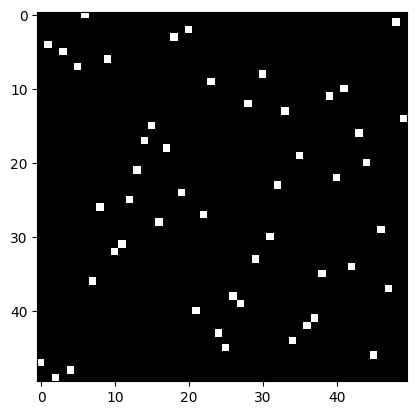

In [3]:
# Test Sinkhorn
nx, ny = 50, 50
crossC = torch.ones(nx, ny).to(torch.float64)
crossC[torch.randperm(nx), torch.randperm(ny)] = 0
intraC1 = torch.rand(nx, ny).to(torch.float64)
intraC2 = torch.rand(nx, ny).to(torch.float64)
S = sinkhorn(crossC, intraC1, intraC2, lambda_w=1, lambda_e=0, lambda_t=1e-2, in_iter=10, out_iter=100)
plt.imshow(S, cmap='gray')
print('Dist: %.20f' % torch.sum(crossC * S)) 

In [101]:
nx, ny = 50, 30
eps = 1e-5
a = torch.ones(nx).to(torch.float64) / nx
b = torch.ones(ny).to(torch.float64) / ny
cost = torch.rand(nx, ny).to(torch.float64)
f = torch.ones(nx).to(torch.float64) / nx
g = torch.ones(ny).to(torch.float64) / ny

def soft_min_row(z_in, eps):
    hard_min = torch.min(z_in, dim=1, keepdim=True)[0]
    soft_min = hard_min - eps * torch.log(torch.sum(torch.exp(-(z_in - hard_min) / eps), dim=1, keepdim=True))
    return soft_min.squeeze(-1)

def soft_min_col(z_in, eps):
    hard_min = torch.min(z_in, dim=0, keepdim=True)[0]
    soft_min = hard_min - eps * torch.log(torch.sum(torch.exp(-(z_in - hard_min) / eps), dim=0, keepdim=True))
    return soft_min.squeeze(0)

for i in range(100000):
    f = soft_min_row(cost - g.view(1, -1), eps) + eps * torch.log(a)
    g = soft_min_col(cost - f.view(-1, 1), eps) + eps * torch.log(b)
    
S = torch.exp((f.view(-1, 1) + g.view(-1, 1).T - cost) / eps)
S += 1e-20
print(torch.sum(cost * S) + eps * torch.sum(S * (torch.log(S) - 1)) + eps)
print(eps * (a.view(1, -1) @ (f/eps).view(-1, 1) + b.view(1, -1) @ (g/eps).view(-1, 1)))

tensor(0.0447, dtype=torch.float64)
tensor([[0.0447]], dtype=torch.float64)


In [102]:
print(S.sum(1))

tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200], dtype=torch.float64)


In [94]:
n = 5
for i in range(100000):
    av = torch.rand(n)
    bv = torch.rand(n)
    av /= -torch.linalg.norm(av, ord=2)
    bv /= -torch.linalg.norm(bv, ord=2)
    s = torch.sum(av * bv)
    if s < -1 or s > 1:
        print('error')

In [117]:
n1, n2 = 1000, 1200
a = torch.rand(n1).to(torch.float64)
a = a / a.sum()
b = torch.rand(n2).to(torch.float64)
b = b / b.sum()
C = torch.rand(n1, n2).to(torch.float64)
eps = 1e-4
global_delta = 1e-6

In [ ]:
# Sinkhorn
u = torch.ones(n1).to(torch.float64) / n1
v = torch.ones(n2).to(torch.float64) / n2
K = torch.exp(-C / eps)

start_time = time.time()
n_iter = 0
while True:
    u = a / (K @ v)
    v = b / (K.T @ u)
    S = torch.diag(u) @ K @ torch.diag(v)
    err1 = torch.sum(torch.abs(torch.sum(S, dim=1) - a))
    err2 = torch.sum(torch.abs(torch.sum(S, dim=0) - b))
    err = err1 + err2
    if err < global_delta:
        break
    if n_iter % 100 == 99:
        print(f'iter: {n_iter + 1}, err: {err:.15f}')
    n_iter += 1
end_time = time.time()
S_ground = torch.clone(S)
print(f'Time: {end_time - start_time:.4f}s')

In [ ]:
# LOT
r = 500
alpha = 1e-5
gamma = 100
delta = 1e-10

Q = torch.ones(n1, r).to(torch.float64) / (n1 * r)
R = torch.ones(n2, r).to(torch.float64) / (n2 * r)
g = torch.ones(r).to(torch.float64) / r


def LR_Dykstra(Ks, a, b, alpha, max_iter=1000, delta=1e-9, lam=0):
    K1, K2, K3 = Ks
    Q = K1
    R = K2
    g_old = K3

    n1, n2 = K1.shape[0], K2.shape[0]
    r = K3.shape[0]
    
    v1_old = torch.ones(r).to(torch.float64)
    v2_old = torch.ones(r).to(torch.float64)
    u1 = torch.ones(n1).to(torch.float64)
    u2 = torch.ones(n2).to(torch.float64)

    q_gi = torch.ones(r).to(torch.float64)
    q_gp = torch.ones(r).to(torch.float64)
    q_Q = torch.ones(r).to(torch.float64)
    q_R = torch.ones(r).to(torch.float64)

    err = 1
    n_iter = 0
    while n_iter < max_iter:
        u1_prev, v1_prev = u1, v1_old
        u2_prev, v2_prev = u2, v2_old
        g_prev = g_old
        if err > delta:
            n_iter += 1

            # First Projection
            u1 = a / (K1 @ v1_old + lam)
            u2 = b / (K2 @ v2_old + lam)
            g = torch.max(torch.tensor(alpha), g_old * q_gi)
            q_gi = (g_old * q_gi) / (g + lam)
            g_old = torch.clone(g)

            # Second Projection
            v1_trans = K1.T @ u1
            v2_trans = K2.T @ u2
            g = (g_old * q_gp * v1_old * q_Q * v1_trans * v2_old * q_R * v2_trans) ** (1 / 3)
            v1 = g / (v1_trans + lam)
            v2 = g / (v2_trans + lam)
            q_gp = (g_old * q_gp) / (g + lam)
            q_Q = (q_Q * v1_old) / (v1 + lam)
            q_R = (q_R * v2_old) / (v2 + lam)

            v1_old = torch.clone(v1)
            v2_old = torch.clone(v2)
            g_old = torch.clone(g)

            # Update the error
            u1_trans = K1 @ v1
            err_1 = torch.sum(torch.abs(u1 * u1_trans - a))
            u2_trans = K2 @ v2
            err_2 = torch.sum(torch.abs(u2 * u2_trans - b))
            err = err_1 + err_2

            if (
                torch.any(torch.isnan(u1)) or
                torch.any(torch.isnan(u2)) or
                torch.any(torch.isnan(v1)) or
                torch.any(torch.isnan(v2)) or
                torch.any(torch.isinf(u1)) or
                torch.any(torch.isinf(u2)) or
                torch.any(torch.isinf(v1)) or
                torch.any(torch.isinf(v2))
            ):
                print(f"Warning: numerical error in Dyskra at iteration {n_iter}")
                u1, v1 = u1_prev, v1_prev
                u2, v2 = u2_prev, v2_prev
                g = g_prev
                break

        else:
            Q = u1.view(-1, 1) * K1 * v1.view(1, -1)
            R = u2.view(-1, 1) * K2 * v2.view(1, -1)
            return Q, R, g, n_iter

    Q = u1.view(-1, 1) * K1 * v1.view(1, -1)
    R = u2.view(-1, 1) * K2 * v2.view(1, -1)
    return Q, R, g, n_iter

epochs = 0
start_time = time.time()
while True:
    xi1 = torch.exp(-gamma * C @ R @ torch.diag(1/g) - (gamma * eps - 1) * torch.log(Q))
    xi2 = torch.exp(-gamma * C.T @ Q @ torch.diag(1/g) - (gamma * eps - 1) * torch.log(R))
    omega = torch.diagonal(Q.T @ C @ R)
    xi3 = torch.exp(gamma * omega / (g ** 2) - (gamma * eps - 1) * torch.log(g))
    Q, R, g, n_iter = LR_Dykstra((xi1, xi2, xi3), a, b, alpha, delta=delta)
    S = Q @ torch.diag(1 / g) @ R.T
    err = torch.sum(torch.abs(S - S_ground))
    if err < global_delta:
        break
    if epochs % 100 == 99:
        print(f'iter: {epochs + 1}, err: {err:.15f}')
    epochs += 1
    
end_time = time.time()
print(f'Time: {end_time - start_time:.4f}s')
print(S.sum())